In [26]:
import pandas as pd

This notebook is part of the Technical Test for applying to the Data Science Internship Position at Torre. It is mainly focused on retrieving insights from the file "reed_uk.csv" by using Data Analysis and a Graph Database (Neo4J). Further work can be done with more time, and better understanding of Cypher Query Language, which resulted really helpful when matching queries.

// Note
You must have a running service of Neo4J locally for this notebook to load the csv into nodes and relationships. This process can take from 1 to 2 hours, due to the size of the data (50k rows and 12 columns). Some Nodes contain data from more than one column.
In this notebook, I used Neo4J Desktop Client, resulting in 93.815 nodes and 180.531 relationships.
There are also some requirements detailed in requirements.txt.

# Initial Data Analysis

In [82]:
csv_file_name = "reed_uk.csv"
df = pd.read_csv(csv_file_name)

In [4]:
df.head(15)

,category,city,company_name,geo,job_board,job_description,job_requirements,job_title,job_type,post_date,salary_offered,state
0,catering jobs,Chudleigh,Haulfryn Group,uk,reed,Apply now New opportunity not to be missed! H...,NaN,Commis Chef,"Permanent, full-time",3/12/2018,"£18,323 per annum",Devon
1,law jobs,Swindon,Reed,uk,reed,Apply now This role requires an experienced s...,NaN,Corporate Legal Secretary,"Permanent, full-time",3/8/2018,"£18,000 - £22,000 per annum",Wiltshire
2,factory jobs,Norfolk,Swanstaff Recruitment Ltd,uk,reed,Apply now Job Title: Warehouse personLocation...,NaN,Warehouse Person,"Permanent, full-time",2/27/2018,Salary not specified,East Anglia
3,law jobs,Hurstpierpoint,Castles Solicitors,uk,reed,Apply now Castles Solicitors are looking for ...,Required skills Admin Case Management Corresp...,Legal Secretary / Admin Assistant,"Permanent, full-time or part-time",2/21/2018,"£15,000 - £17,000 per annum, pro-rata",West Sussex
4,factory jobs,Hertfordshire,Marketplace Group,uk,reed,Apply now International Pharmaceutical Manufa...,NaN,Category Planner - Pharmaceutical,"Permanent, full-time",3/1/2018,"£37,000 - £45,000 per annum",South East England
5,retail jobs,Belfast,Vodafone,uk,reed,Apply on employer's website Retail Advisor - ...,NaN,Retail Adviser 20hrs/week - Belfast Donnegal P...,"Permanent, part-time",3/12/2018,"£9,100 - £9,152 per annum, OTE",County Antrim
6,factory jobs,Thetford,Hales Group Limited,uk,reed,"Apply now Break Press Operator - Permanent, Â...",NaN,Break Press Operator,"Permanent, full-time",2/28/2018,£9.25 - £10.15 per hour,Norfolk
7,motoring automotive jobs,Luton,Fine Recruiting Ltd,uk,reed,Apply now An exciting opportunity to start wi...,Required skills Accident Paint Repair Spray P...,Vehicle Paint Sprayer,"Permanent, full-time",3/2/2018,"£35,000 - £40,000 per annum",Bedfordshire
8,motoring automotive jobs,Blackburn,Audi,uk,reed,Apply on employer's website This exciting opp...,NaN,Vehicle Technician,"Permanent, full-time",2/28/2018,"£23,000 - £26,600 per annum",Lancashire
9,law jobs,Leeds,Rachel Clark Legal Recruitment,uk,reed,"Apply now This highly regarded, top law firm ...",Required skills Diary Management Legal Secret...,LEGAL SECRETARY,"Permanent, full-time",3/12/2018,"£18,000 - £25,000 per annum, inc benefits",West Yorkshire


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   category          50000 non-null  object
 1   city              50000 non-null  object
 2   company_name      50000 non-null  object
 3   geo               50000 non-null  object
 4   job_board         50000 non-null  object
 5   job_description   50000 non-null  object
 6   job_requirements  20548 non-null  object
 7   job_title         50000 non-null  object
 8   job_type          50000 non-null  object
 9   post_date         50000 non-null  object
 10  salary_offered    50000 non-null  object
 11  state             49980 non-null  object
dtypes: object(12)
memory usage: 4.6+ MB


At a first glance, we notice that the row column job_requirements contains less than half of the total records non-null values. These job offers may be considered internships or jobs for novice and could be later analyzed to see the distribution of the job offers by categories and/or location.

Additionally, There are 20 states missing in the records that must be filled with a value, such as "Other".

In [85]:
# Checking country values
countries = df.geo
print(countries.unique())

['uk']


uk is the only country listed, it can be ignored in the graph

In [7]:
job_board = df.job_board
print(job_board.unique())

['reed']


reed is the only value in the job_board column, it can be ignored in the graph

In [86]:
categories = df.category
unique_categories = categories.unique()
print(categories.value_counts().sort_values(ascending=False))

health jobs                           1930
education jobs                        1898
it jobs                               1890
logistics jobs                        1885
construction property jobs            1859
engineering jobs                      1858
accountancy jobs                      1856
sales jobs                            1855
accountancy qualified jobs            1836
social care jobs                      1823
admin secretarial pa jobs             1799
finance jobs                          1793
factory jobs                          1755
recruitment consultancy jobs          1747
motoring automotive jobs              1578
retail jobs                           1559
customer service jobs                 1548
catering jobs                         1536
law jobs                              1535
marketing jobs                        1463
other jobs                            1452
hr jobs                               1366
banking jobs                          1097
science job

In [87]:
print("There are %d unique categories in the dataset" % unique_categories.size)

There are 37 unique categories in the dataset


In [88]:
# Check how many unique job titles are there in the dataset and its count
num_unique_titles = df.job_title.unique().size
print(df.job_title.value_counts()[:15].sort_values(ascending=False))

Administrator               162
Customer Service Advisor    145
Management Accountant       139
Warehouse Operative         131
Recruitment Consultant      120
Buyer                       111
Account Manager             111
Care Assistant              111
Vehicle Technician          108
Support Worker              107
Sales Executive             102
Accounts Assistant          101
Finance Manager              99
HR Administrator             94
Project Manager              89
Name: job_title, dtype: int64


In [10]:
print("----------------------------")
# Checking how many unique companies are there in the dataset
companies = df.company_name
print("There are %d unique companies" % len(companies.unique()))
print(companies.value_counts()[:15].sort_values(ascending=False))

----------------------------
There are 5166 unique companies
Hays Specialist Recruitment Limited                 1830
Reed                                                 804
Search Consultancy                                   534
Pareto                                               450
Adecco UK Limited                                    355
SW6 Associates Ltd                                   302
Randstad Construction, Property and Engineering      287
Rise Technical Recruitment Limited                   280
Interaction Recruitment                              267
Reed Accountancy                                     266
G2 Legal Limited                                     223
Auto Skills UK                                       215
ESG Recruitment                                      196
Page Personnel Finance                               193
Reed Insurance                                       185
Name: company_name, dtype: int64


In [89]:
print("There are %d unique job titles" % num_unique_titles)

There are 29155 unique job titles


In [41]:
# Checking skills values
requirements = df.job_requirements
requirements_not_null = requirements[requirements.notnull()].apply(lambda req: req.replace("Required skills", ""))
print(requirements_not_null.unique().size)
requirements_not_null.value_counts()[:15].sort_values(ascending=False)

14887


  Recruitment                                                                                                                                                                             123
  Customer Service                                                                                                                                                                         84
  Buying Category Procurement Purchase Purchasing Sourcing Supply Chain Buyer Purchaser                                                                                                    59
  Sales                                                                                                                                                                                    52
  QTS                                                                                                                                                                                      46
  Mobile Patrol Security SIA retail SIA Licence Se

There are 20548 skills required for differents jobs, but only 14887 are unique. The words Required Skills can be ignored.

# NEO4J PRE-VISUALIZATION

We use Neo4J as a Graph Database to have a better understanding of the relationships formed between different Job Offers. Many techniques of social network analysis can be implemented to get insights about the database and to offer better job suggestions while using Torre.

In [2]:
from py2neo import Graph, Node, Relationship

In [3]:
graph = Graph("bolt://localhost:7687", auth=('neo4j', 'password'))

In [ ]:
graph.delete_all()

graph.run("CREATE CONSTRAINT ON (co:Company) ASSERT co.name IS UNIQUE")
graph.run("CREATE CONSTRAINT ON (jr:JobRequirement) ASSERT jr.name IS UNIQUE")
graph.run("CREATE CONSTRAINT ON (jt:JobTitle) ASSERT jt.name IS UNIQUE")
graph.run("CREATE CONSTRAINT ON (ct:City) ASSERT ct.name IS UNIQUE")
graph.run("CREATE CONSTRAINT ON (st:State) ASSERT st.name IS UNIQUE")
graph.run("CREATE CONSTRAINT ON (cat:Category) ASSERT cat.name IS UNIQUE")

We define the graph constraints so that there is no repeated values when merging new nodes into the graph.

In [64]:
for index, row in df.iterrows():
    job_title = Node("JobTitle", name=row.job_title.lower())
    job_title.__primarylabel__ = "JobTitle"
    job_title.__primarykey__ = "name"
    graph.merge(job_title)
    
    job_offer = Node("Job Offer", name=row.job_description, job_type=row.job_type,salary=row.salary_offered)
    job_offer.__primarylabel__ = "Job Offer"
    job_offer.__primarykey__ = "name"
    graph.merge(job_offer)
    
    graph.merge(Relationship(job_title, "HAS", job_offer))
    
    category = Node("Category", name=row.category.lower())
    category.__primarylabel__ = "Category"
    category.__primarykey__ = "name"
    graph.merge(category)
    
    graph.merge(Relationship(job_title, "BELONGS TO", category))
    
    city = Node("City", name=row.city.lower())
    city.__primarylabel__ = "City"
    city.__primarykey__ = "name"
    graph.merge(city)
    
    # Some States are NaN
    raw_state = row.state
    if not pd.isna(raw_state):
        state = Node("State", name=row.state.lower())
    else:
        state = state = Node("State", name="other")
        
    state.__primarylabel__ = "State"
    state.__primarykey__ = "name"
    graph.merge(state)
    
    graph.merge(Relationship(city, "LOCATED IN", state))
    graph.merge(Relationship(job_offer, "OFFERED IN", city))
    
    company = Node("Company", name=row.company_name.lower())
    company.__primarylabel__ = "Company"
    company.__primarykey__ = "name"
    graph.merge(company)
    
    graph.merge(Relationship(job_offer, "OFFERED BY", company))
    
    raw_job_requirement = row.job_requirements
    if not pd.isna(raw_job_requirement):
        job_requirement = Node("JobRequirement", name=raw_job_requirement.lower().replace("required skills", ""))
        job_requirement.__primarylabel__ = "JobRequirement"
        job_requirement.__primarykey__ = "name"
        graph.merge(job_requirement)
        
        graph.merge(Relationship(job_offer, "REQUIRES", job_requirement))

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt

In [97]:
query = """
MATCH (jt:JobTitle)-[r: `BELONGS TO`]->(ct:Category)
RETURN jt.name AS name, count(*) AS count
"""
result = graph.run(query).data()

In [98]:
result_df = pd.DataFrame(result).sort_values(by=["count"], ascending=False)
print(result_df)

                                                  name  count
2514                      business development manager     18
216                                    account manager     18
2010                                   project manager     17
789                                 operations manager     16
2605                                     administrator     15
...                                                ...    ...
10038  healthcare scientist team manager bms 2 2 posts      1
10037                       advisor - child protection      1
10036                                  pharmacist bank      1
10035                         patient access assistant      1
28701                          social media specialist      1

[28702 rows x 2 columns]


The job titles that belong to more categories. It can reflect which job titles are more likely to have more requirement skills in common to others.

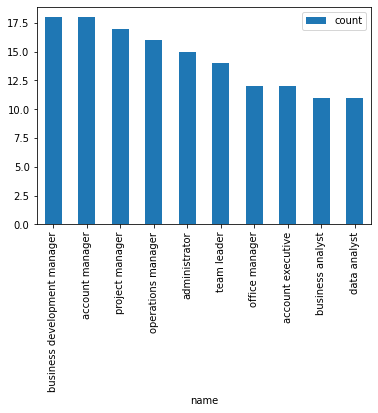

In [99]:
jobs_with_more_categories = result_df.iloc[:10,:].plot.bar(x="name",rot=90)

In [78]:
query2 = """
MATCH (jt1:JobTitle)-[:`BELONGS TO`]->(ct:Category),
      (jt1)-[:HAS]-> (jo: `Job Offer`) -[:REQUIRES]->(jr1:JobRequirement),
      (jt2:JobTitle)-[:`BELONGS TO`]->(ct),
      (jt2)-[:HAS]-> (jo2:`Job Offer`) -[:REQUIRES]->(jr1)
WHERE ct.name = $name AND jt1.name < jt2.name
RETURN jt1.name AS JobTitle1, jt2.name as JobTitle2, count(*) as CommonSkills
"""
result2 = graph.run(query2, name="catering jobs").data()

In [79]:
result_df2 = pd.DataFrame(result2).sort_values(by=["CommonSkills"], ascending=False)
print(result_df2)

                                            JobTitle1  \
70                                  assistant manager   
28                                  assistant manager   
126                                 assistant manager   
202                                 assistant manager   
121                                 assistant manager   
..                                                ...   
96                   assistant manager - spread eagle   
97                     assistant manager- oxon priory   
98   assistant manager - fox and crown, flaming grill   
99                          assistant manager, dundee   
256                       head chef / kitchen manager   

                            JobTitle2  CommonSkills  
70       assistant manager- sun hotel             8  
28    assistant manager- rose revived             8  
126    assistant manager- oxon priory             8  
202     assistant manager- robin hood             8  
121  assistant manager - spread eagle        

One approach to consider if two job offers are connected is by analyzing how many skills or job requirements they have in common. Job Titles that have more Job Requirements in common may suggest a better grade of compatiblity between them .By defining a category or city, this can result in better job suggestions when applying to one job. Clustering by cities can improve even more the suggestions accuracy.

In [75]:
query3 = """
MATCH (jt1:JobTitle)-[:`BELONGS TO`]->(ct1:Category),
      (jt1)-[:`BELONGS TO`]->(ct2:Category)
WHERE ct1.name < ct2.name 
RETURN ct1.name AS Category1, ct2.name as Category2, count(*) as CommonJobTitles
"""
result3 = graph.run(query3).data()

In [96]:
result_df3 = pd.DataFrame(result3).sort_values(by=["CommonJobTitles"], ascending=False)
print(result_df3.iloc[:20,:])

                      Category1                    Category2  CommonJobTitles
276            engineering jobs                 factory jobs               90
342            accountancy jobs   accountancy qualified jobs               59
108              marketing jobs  media digital creative jobs               56
60                 factory jobs                    fmcg jobs               56
260  construction property jobs             engineering jobs               52
49                 factory jobs               logistics jobs               47
193                 health jobs             social care jobs               47
308   admin secretarial pa jobs        customer service jobs               42
145       customer service jobs                   sales jobs               42
500                banking jobs                 finance jobs               36
345            accountancy jobs                 finance jobs               36
55                 factory jobs                   other jobs    

By analyzing the Graph, I noticed that sometimes a job title belongs to more than one category. We can use the same approach as before to get how related are two categories, and make more job titles suggestions between categories that are really closed to the job that was first searched.

# Conclusions

Job Titles that belong to more categories may have more skills in common with others that are not commonly associated with.
The most connected categories are Engineering and Factory Jobs, followed by Accountancy and Marketing - Media Digital Jobs.
Further work is needed to analyze "other jobs" category and its main requirements, so it can fit in another category.

# Reflections on the work done

Neo4J resulted in a really powerful tool to identify patterns and insights when working with networks analysis. Even though it can take a long time to create the nodes and relationships.
I spent too much time thinking and sketching the architecture of the graph instead of trying out different architectures with small samples. I could have used that time to improve the depth of the network.
Due to the lack of time, i did not consider relationships between Companies and Skills.

# Further Work

The approaches I took to consider how connected are two nodes was based in a path lenght of 1. I could have used more metrics like betweeness and closeness.
Community Detection algorithms could lead to more insights about how close job titles really are.
When defining communities of job titles/offers, a machine learning algorithm could be trained to estimate salaries.